This Exam Question 4

1. Make a function that can realize a multivariate standard Wiener process

(10, 1000)


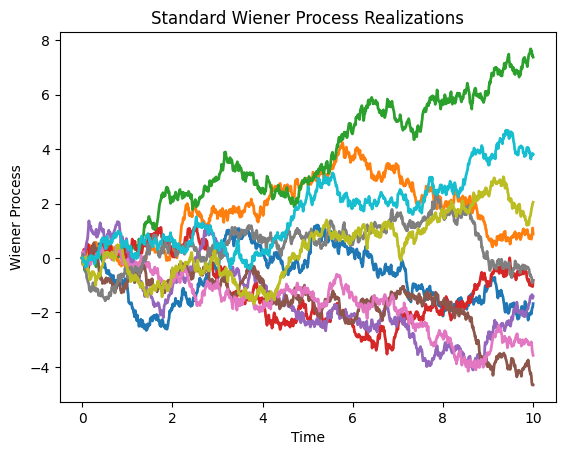

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def scalar_std_wiener_process(T, N, Ns, seed=None):
    """
    Generates Ns realizations of a standard scalar Wiener process.
    
    Parameters:
    T : Final time.
    N : Number of intervals.
    Ns : Number of realizations.
    seed : int, optional
        Seed for the random number generator.
    
    Returns:
    W : ndarray
        Standard Wiener process in [0,T].
    Tw : ndarray
        Time points.
    dW : ndarray
        White noise used to generate the Wiener process.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(Ns, N)
    W = np.hstack((np.zeros((Ns, 1)), np.cumsum(dW, axis=1)))
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW


def StdWienerProcess(T, N, nW, Ns, seed=None):
    """
    Generates Ns realizations of a standard Wiener process.
    
    Parameters:
    T    : Final time
    N    : Number of intervals
    nW   : Dimension of W(k)
    Ns   : Number of realizations
    seed : To set the random number generator (optional)
    
    Returns:
    W    : Standard Wiener process in [0,T]
    Tw   : Time points
    dW   : White noise used to generate the Wiener process
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW

# Example usage
T, N, Ns, seed = 10, 1000, 10, 100
W, Tw, dW = scalar_std_wiener_process(T, N, Ns, seed)
print(dW.shape)
plt.plot(Tw, W.T, linewidth=2)
plt.xlabel("Time")
plt.ylabel("Wiener Process")
plt.title("Standard Wiener Process Realizations")
plt.show()


2. Implement the explicit-explicit method with fixed step size

In [3]:
## import numpy as np

def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, *args):
    """
    Solves an SDE using an explicit-explicit Euler-Maruyama scheme.

    Parameters:
    ffun : function
        Drift function f(t, x, *args).
    gfun : function
        Diffusion function g(t, x, *args).
    T : ndarray
        Array of time points.
    x0 : ndarray
        Initial condition.
    W : ndarray
        Wiener process increments (same shape as T).
    *args : tuple
        Additional parameters for ffun and gfun.

    Returns:
    X : ndarray
        Solution of the SDE at end
    """
    # Number of timesteps
    N = len(T)
    # Number of dimensions of x
    nx = len(x0)
    # Allocating space for the solution 
    X = np.zeros((nx, N))
    # Storing the initial value in X
    X[:, 0] = x0


    for k in range(N - 1):
        # Timestep
        dt = T[k + 1] - T[k]
        # White noise 
        dW = W[:, k + 1] - W[:, k]
        
        # Evaluating the drift function
        f,_ = ffun(T[k], X[:, k], *args)
        
        # Evaluating the diffusion function
        g = gfun(T[k], X[:, k], *args)
        
        # SDE psi definition
        psi = X[:, k] + g * dW  

        # Explicit step to get Xk+1
        X[:, k + 1] = np.array(psi) + np.array(f) *np.array(dt)
    return X

def VanderpolDrift(t, x, p):
    mu = p[0]
    
    tmp = mu * (1.0 - x[0]**2)
    
    f = np.zeros(2)
    f[0] = x[1]
    f[1] = tmp * x[1] - x[0]
    
    if len(locals()) > 3:  # Check if we need the Jacobian matrix
        J = np.array([[0, 1], 
                      [-2 * mu * x[0] * x[1] - 1.0, tmp]])
        return f, J
    return f, []


def VanderPolDiffusion1(t, x, p):
    sigma = p[1]  # Assuming p is a list or numpy array
    g = np.array([0.0, sigma])
    return g



#def VanderPolDiffusion1_(t, x, p):
#    sigma = p[1]  # Extract sigma
#    g = np.array([[0.0], [sigma]])  # Reshape to (2,1)
#    return g


#this is from week 6



3. Implement the implicit-explicit method with fixed step size

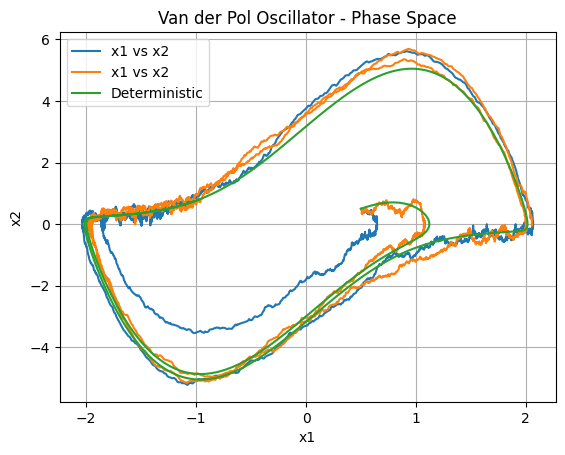

In [7]:
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, *args):
    tol = 1.0e-8            # Tolerance
    maxit = 100             # Max iterations
    
    N = len(T)              # Time steps
    nx = len(x0)            # Dimensions of solution
    X = np.zeros((nx, N))   # Allocating space for solution over time
    X[:, 0] = x0            # Storing initial x in X
    
    for k in range(N - 1):
        # Evaluating the diffusion term
        g = gfun(T[k], X[:, k], *args)
        # Timestep
        dt = T[k + 1] - T[k]
        
        # Corresponding white noise
        dW = W[:, k + 1] - W[:, k]
        
        # SDE definition for psi
        psi = X[:, k] + g * dW

        # Evaluating the drift term
        f,_ = ffun(T[k], X[:, k], *args)

        # Using the explicit as initial guess
        xinit = np.array(psi) + np.array(f) * np.array(dt)

        # Implicit step
        X[:, k + 1] = SDENewtonSolver(
            ffun, T[k + 1], dt, psi, xinit, tol, maxit, *args
        )
    
    return X


def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))      # Identity matrix size x
    x = xinit                   # Initial guess
    f, J = ffun(t, x, *args)    # Evaluating function for f val and jacobian
    R = x - f * dt - psi        # Residual function
    it = 1                      # Iteration count
    
    # While residual is larger than the tolerance
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        # Jacobian of residual
        dRdx = I - J * dt   
        # Change in x
        mdx = np.linalg.solve(dRdx, R)
        # Update x
        x = x - mdx
        # Compute function value and jacobian
        f, J = ffun(t, x, *args)
        # Residual
        R = x - f * dt - psi
        # Iteration count
        it += 1
    #what is this one changing for each iteration? The step 

    return x


# Van der Pol parameter
mu = 3
# Noise value
sigma = 0.5
# Parameters
p = np.array([mu, sigma])
# Initial value 
x0 = np.array([0.5, 0.5])

# Time frame
tf = 5 * mu
# Dimensions of W(k)
nw = 2
# Number of intervals
N = 5000
# Number of realizations
Ns = 5
# Reproducability
seed = 100

# Generate standard Wiener process
W, T, dW = StdWienerProcess(tf, N,nw ,Ns, seed)
# Initialize solution array
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each sample path
for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )


# Solve deterministic case
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], np.array([mu, 0.0])
)


plt.figure()
plt.plot(X[0,:, 0], X[1,:, 0], label='x1 vs x2')
plt.plot(X[0,:, 1], X[1,:, 1], label='x1 vs x2')
plt.plot(Xd[0,:,], Xd[1,:], label='Deterministic')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Van der Pol Oscillator - Phase Space')
plt.grid()
plt.show()


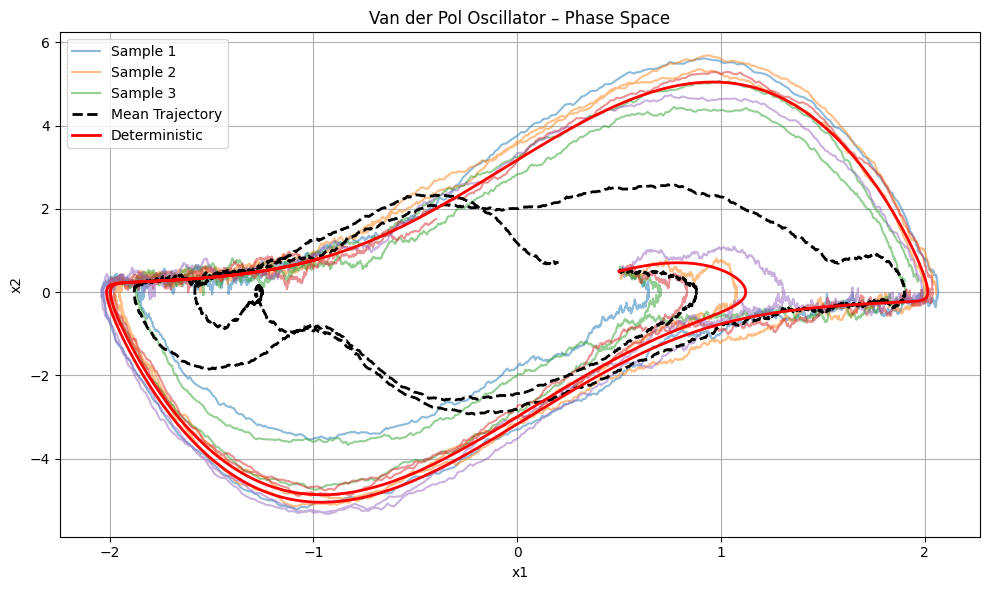

Describe the implementations and the idea we use in the deriving the methods


Explicite-Explicit:

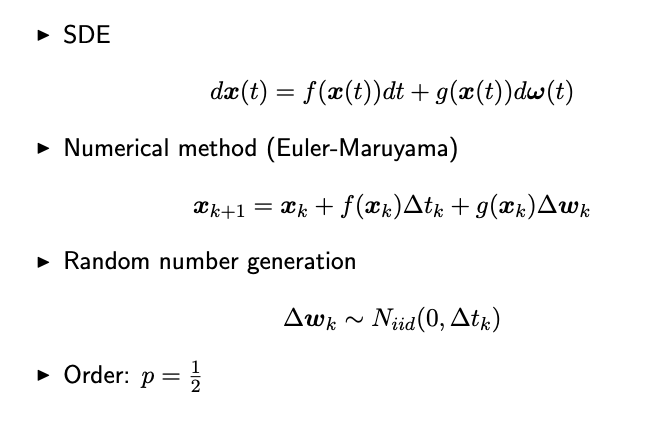


Implicit-Explicit:

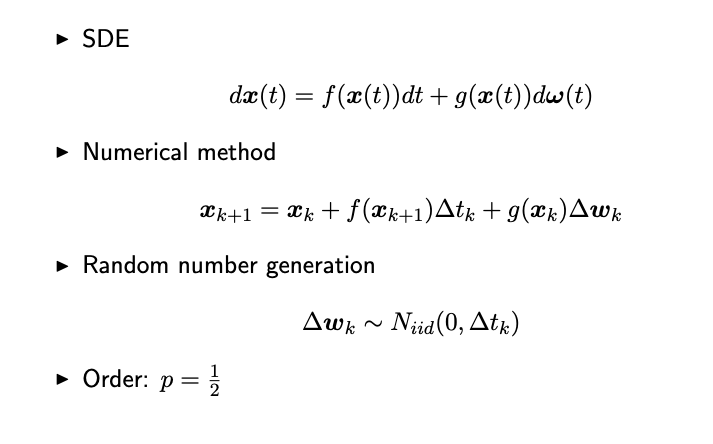

the big difference is that the implicit-explicit method has f(xk+1) term

Making SDE extensions of my test problems in 1.
This includes
- prey pred
- van der pool (done)
- CSTR 3 state
- CSTR 1 state
- PFR 3 state
- PFR 1 state



Van der pool 
\begin{align}
dx_1(t) &= x_2(t) \, dt \\
dx_2(t) &= \left[ \mu \left(1 - x_1(t)^2\right) x_2(t) - x_1(t) \right] dt + \sigma \, dW(t)
\end{align}

where:

%\begin{itemize}
%  \item \( x_1(t) \) is the position,
%  \item \( x_2(t) \) is the velocity,
%  \item \( \mu > 0 \) controls the nonlinearity and damping,
%  \item \( \sigma \) is the noise intensity,
%  \item \( W(t) \) is a standard Wiener process.
%\end{itemize}



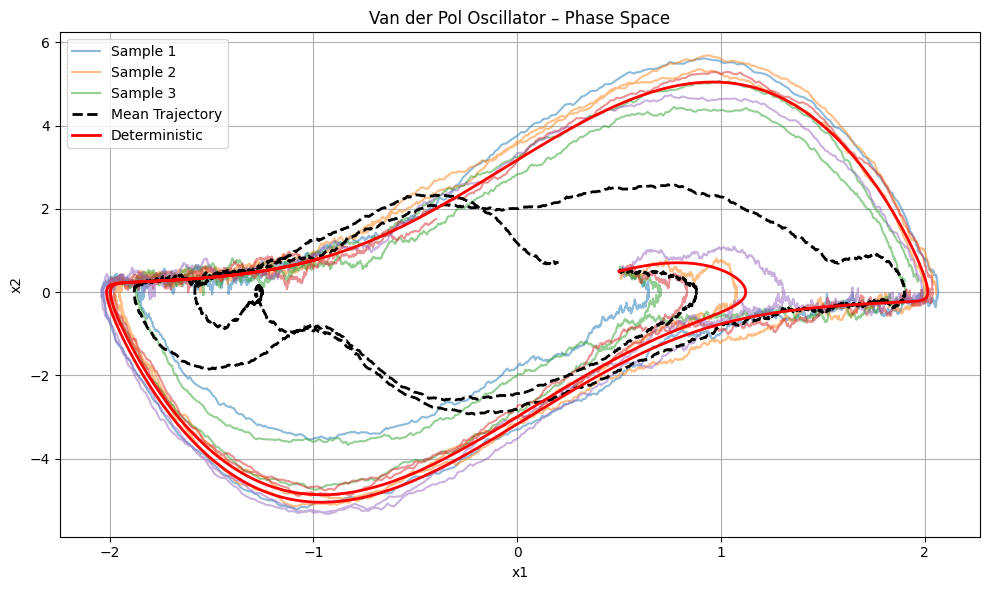

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 3
sigma = 0.5
p = np.array([mu, sigma])
x0 = np.array([0.5, 0.5])

tf = 5 * mu     # Final time
nw = 2          # Noise dimension
N = 5000        # Number of intervals
Ns = 5          # Number of sample paths
seed = 100      # Reproducibility

# Generate Wiener process: shape W = (nw, N+1, Ns)
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# Storage for solutions: shape (state_dim, time_steps, samples)
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each realization
for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )

# Solve deterministic system (σ = 0)
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, 0], np.array([mu, 0.0])
)

# Compute mean trajectory over Ns realizations
X_mean = np.mean(X, axis=2)

# === Plotting ===

plt.figure(figsize=(10, 6))

# Plot sample paths in phase space
for i in range(Ns):
    plt.plot(X[0, :, i], X[1, :, i], alpha=0.5, label=f'Sample {i+1}' if i < 3 else None)

# Mean trajectory
plt.plot(X_mean[0], X_mean[1], 'k--', label='Mean Trajectory', linewidth=2)

# Deterministic solution
plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Van der Pol Oscillator – Phase Space')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


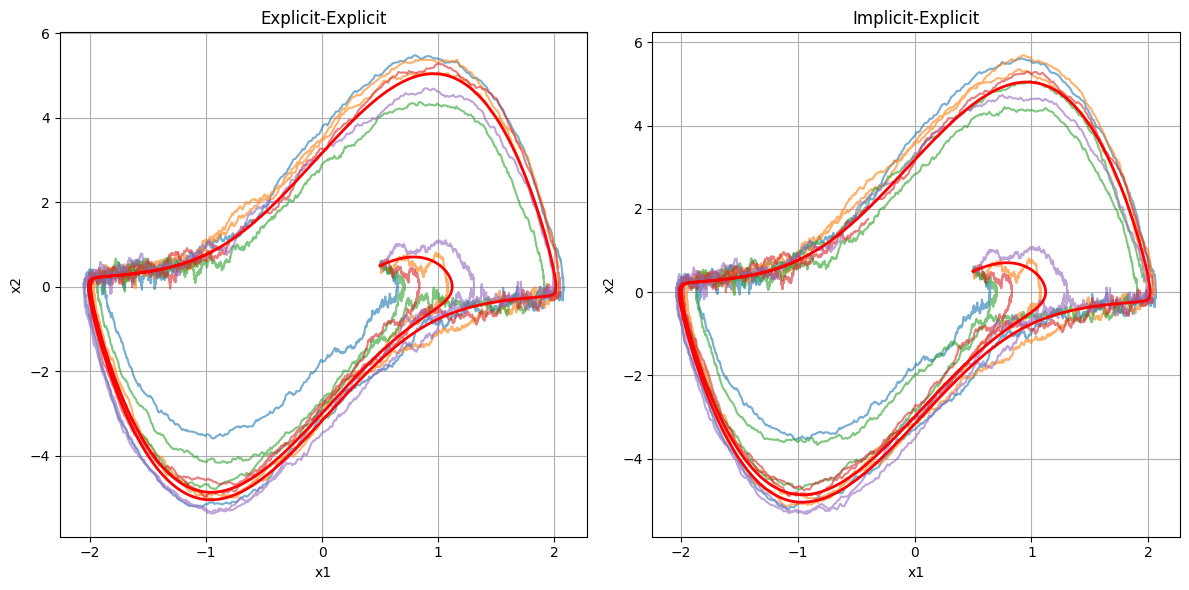

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 3
sigma = 0.5
p = np.array([mu, sigma])
x0 = np.array([0.5, 0.5])

tf = 5 * mu     # Final time
nw = 2          # Noise dimension
N = 5000        # Time steps
Ns = 5          # Number of sample paths
seed = 100      # Reproducibility

# Generate Wiener process (shape: W = (nw, N+1, Ns))
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# Allocate space for solutions
X_exp = np.zeros((len(x0), N + 1, Ns))
X_imp = np.zeros((len(x0), N + 1, Ns))

# Solve for each sample path
for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(VanderpolDrift, VanderPolDiffusion1, T, x0, Wi, p)
    X_imp[:, :, i] = SDEsolverImplicitExplicit(VanderpolDrift, VanderPolDiffusion1, T, x0, Wi, p)

# Solve deterministic system (σ = 0)
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, 0], np.array([mu, 0.0])
)
# Plot results
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)



plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.title('Explicit-Explicit')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.title('Implicit-Explicit')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

plt.tight_layout()
plt.show()


Next Prey pred:

additive noise, state independent
\begin{align*}
dx_1(t) &= a(1 - x_2(t))x_1(t) \, dt + \sigma_1 \, dW_1(t) \\
dx_2(t) &= -b(1 - x_1(t))x_2(t) \, dt + \sigma_2 \, dW_2(t)
\end{align*}

For multiplicative noise, state dependent (makes more sense for prey pred)

\begin{align*}
dx_1(t) &= a(1 - x_2(t)) \, x_1(t) \, dt + \sigma_1 \, x_1(t) \, dW_1(t) \\
dx_2(t) &= -b(1 - x_1(t)) \, x_2(t) \, dt + \sigma_2 \, x_2(t) \, dW_2(t)
\end{align*}

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- Prey-Predator Drift Function and Jacobian ---
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)

    f = [dx1, dx2]
    J = [[dx1x1, dx1x2], [dx2x1, dx2x2]]
    return f, J

# --- Diffusion Function (Additive noise) ---
def PreyPredatorDiffusion(t, x, p):
    sigma1 = p[2]
    sigma2 = p[3]
    return np.array([sigma1, sigma2])

# --- Parameters ---
a = 1.0      # prey growth rate
b = 0.5      # predator loss rate
sigma1 = 0.1 # prey noise
sigma2 = 0.1 # predator noise
p = [a, b, sigma1, sigma2]

x0 = np.array([1.0, 0.5])   # Initial populations
tf = 30.0                   # Final time
N = 5000                    # Number of time steps
nw = 2                      # 2D noise (1 per species)
Ns = 5                      # Number of sample paths
seed = 42                   # Reproducibility

# --- Generate Wiener Process ---
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Allocate Solution Arrays ---
X_exp = np.zeros((2, N + 1, Ns))
X_imp = np.zeros((2, N + 1, Ns))

a, b, sigma1, sigma2 = p

for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, a, b, sigma1, sigma2)
    X_imp[:, :, i] = SDEsolverImplicitExplicit(PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, a, b, sigma1, sigma2)

# --- Simulate Each Sample Path ---
for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, *p)
    X_imp[:, :, i] = SDEsolverImplicitExplicit(PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, *p)

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Explicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Implicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

plt.tight_layout()
plt.show()


TypeError: PreyPredator_Fun_Jac() takes 4 positional arguments but 6 were given

0
1
2
3
4


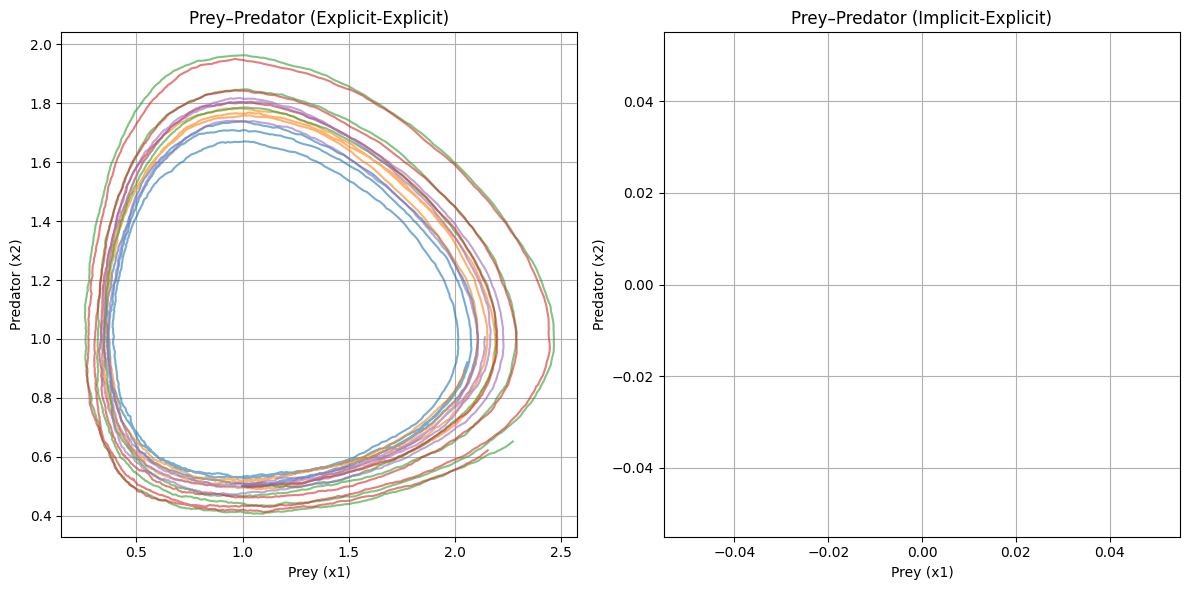

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# --- Prey-Predator Drift Function and Jacobian ---
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)

    f = [dx1, dx2]
    J = [[dx1x1, dx1x2], [dx2x1, dx2x2]]
    return f, J

# --- Diffusion Function (Additive Noise) ---
def PreyPredatorDiffusion(t, x, sigma1, sigma2):
    return np.array([sigma1, sigma2])

# --- Newton Solver ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))
    x = xinit
    f, J = ffun(t, x, *args)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = I - np.array(J) * dt
        mdx = np.linalg.solve(dRdx, R)
        x = x - mdx
        f, J = ffun(t, x, *args)
        f = np.array(f)

        R = x - f * dt - psi
        it += 1
    return x

def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        X[:, k + 1] = np.array(psi) + np.array(f) * dt
    return X

def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = np.array(psi) + np.array(f) * dt
        X[:, k + 1] = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
    return X
# --- StdWienerProcess (Helper) ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Parameters ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.1, 0.1
x0 = np.array([1.0, 0.5])
tf = 30.0
N = 2000
nw = 2
Ns = 5
seed = 42
p_drift = [a, b]
p_diff = [sigma1, sigma2]

# --- Generate Wiener Process ---
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Allocate Solution Arrays ---
X_exp = np.zeros((2, N + 1, Ns))
X_imp = np.zeros((2, N + 1, Ns))

# --- Solve for each sample path ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.01, 0.01
fargs = (a, b)
gargs = (sigma1, sigma2)

for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, fargs, gargs
    )
    #X_imp[:, :, i] = SDEsolverImplicitExplicit(
    #    PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0, Wi, fargs, gargs
    #)
# --- Plotting ---
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    print(i)
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Explicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Implicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

plt.tight_layout()
plt.show()


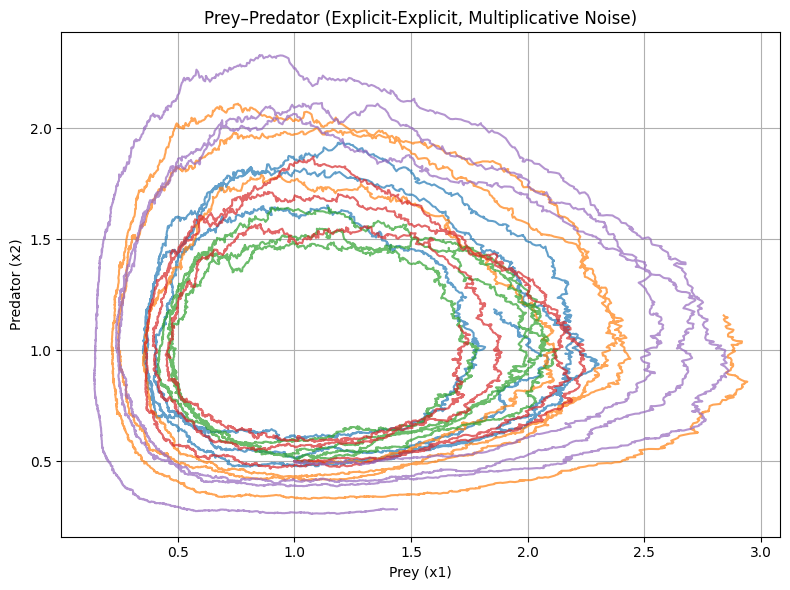

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# --- Drift function and Jacobian ---
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)

    f = [dx1, dx2]
    J = [[dx1x1, dx1x2], [dx2x1, dx2x2]]
    return f, J

# --- Multiplicative noise diffusion ---
def PreyPredatorMultiplicativeDiffusion(t, x, sigma1, sigma2):
    x1, x2 = x
    return np.array([sigma1 * x1, sigma2 * x2])

# --- Explicit-explicit SDE solver ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + np.array(f) * dt + np.array(g) * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)  # keep it bounded
    return X

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Parameters ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.05, 0.05  # Mild multiplicative noise
x0 = np.array([1.0, 0.5])
tf = 30.0
N = 5000
nw = 2
Ns = 5
seed = 42
fargs = (a, b)
gargs = (sigma1, sigma2)

# --- Generate Wiener process ---
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Run explicit solver for each path ---
X = np.zeros((2, N + 1, Ns))
for i in range(Ns):
    Wi = W[:, :, i]
    X[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )

# --- Plotting ---
plt.figure(figsize=(8, 6))
for i in range(Ns):
    plt.plot(X[0, :, i], X[1, :, i], alpha=0.7)
plt.title('Prey–Predator (Explicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()
plt.tight_layout()
plt.show()


It would make sense to add multiplicative noise, as it would be more realistic towards real life.

If the noise is set up, the problem explodes


In [ ]:
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1= a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1,dx2]

# Jacobian of prey predator valuation
def PreyPredator_Jac(t, x, a, b):
    x1, x2 = x
    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    x2_ = -b * (1 - x[0]) * x[1]
    return [[dx1x1, dx1x2], [dx2x1, dx2x2]]


def PreyPredatorDrift(t, x, *args):
    a, b, _ = args
    dx = PreyPredator(t, x, a, b)         # shape (2,)
    J = PreyPredator_Jac(t, x, a, b)      # shape (2, 2)
    return dx, J

def PreyPredatorDiffusion(t, x, *args):
    sigma = args[-1]
    print("This is the shape: ", sigma.shape)
    return np.array([0.0, sigma])


a, b = 1.0, 0.5
sigma = 0.3
x0 = np.array([1.0, 0.5])
p = np.array([a, b, sigma])

tf = 20
nw = 2
N = 5000
Ns = 5
seed = 123


W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)
X = np.zeros((len(x0), N + 1, Ns))


for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        PreyPredatorDrift, PreyPredatorDiffusion, T, x0, W[:, :, i], p
    )


# Deterministic
Xd = SDEsolverImplicitExplicit(
    PreyPredatorDrift, PreyPredatorDiffusion, T, x0, W[:, :, 0], a, b, 0.0
)

# Plotting
plt.figure()
plt.plot(X[0,:, 0], X[1,:, 0], label='Sample path 1')
plt.plot(X[0,:, 1], X[1,:, 1], label='Sample path 2')
plt.plot(Xd[0,:], Xd[1,:], label='Deterministic')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.legend()
plt.title('Prey-Predator Phase Space')
plt.grid()
plt.show()



This is the shape:  (3,)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

4. Describe your implementations and the idea you use in deriving the methods.

5. Make SDE extensions of your test problems in Problem 1